In [166]:
%matplotlib inline

In [167]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [168]:
def load_directory(path):
    onlyfiles = ["%s/%s" %(path, f) for f in listdir(path) if isfile(join(path, f))]
    dfs = []
    
    for f in onlyfiles:
        dfs.append(pd.read_csv(f, sep='\t'))
    return pd.concat(dfs)

In [169]:
def plot_experiment(xp_path):
    df = load_directory(xp_path)
    gpdf = df.groupby(["sim_step", "xp_name"]).agg(np.mean).reset_index().set_index("sim_step")
    max_index = int(math.ceil(gpdf[["eps_min_diff", "eps_min_sstab"]].max().max()) + 2)
    max_index_diff = int(math.ceil(gpdf[["eps_min_diff"]].max().max()))
    max_index_sstab = int(math.ceil(gpdf[["eps_min_sstab"]].max().max()))    
    
    ltx_table = pd.concat([gpdf[gpdf.index==max_index_diff*50], gpdf[gpdf.index==max_index_sstab*50]])
    
    with open("outputs/csv/%s.tex" %xp_path, "w+") as fp:
        ltx_table = ltx_table[["nmsg_diff", "delta_diff", "energy_diff", "nmove_diff",
                               "nmsg_sstab", 
                               "delta_sstab", "energy_sstab", "nmove_sstab"]]
        new_cols = []
        ltx_table["Time"] = ltx_table.index
        ltx_table["Algorithm"] = ["Diffusion", "Self-stab"]
        ltx_table["Degree"] = gpdf["degree_sstab"]
        ltx_table = ltx_table[list(ltx_table.columns)[-3:] + list(ltx_table.columns)[:-3]]
        for col in ltx_table.columns:
            if col.endswith("_sstab"):
                new_cols.append(("Self-stab", col.split("_")[0]))
            elif col.endswith("_diff"):
                new_cols.append(("Diffusion", col.split("_")[0]))
            else:
                new_cols.append(("\multicolumn{3}{c}{}", col))
        print new_cols
        ltx_table.columns = pd.MultiIndex.from_tuples(new_cols)
        desc = xp_path.replace("-", " and ").replace("_", " ")
        label = xp_path.replace("-", "").replace("_", "")
        fp.write("\\begin{figure}\caption{Convergence iterations for experiment $description \label{tab:$label}}".replace("$xp_path", xp_path).\
                 replace("$description", desc).replace("$label", label))
        fp.write(ltx_table.to_latex(index=False, bold_rows=True, escape=False, 
                                    multirow=True, float_format="%.3lf", 
                                    column_format="r|l|r|r|r|r|r|r|r",
                                    multicolumn_format="|c"))        
        fp.write("\end{figure}")
        fp.write("""
\\begin{figure}
  \caption{Experiment with $description \label{fig:$label}}
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_delta.png}
    \caption{Maximum delta convergence \label{fig:$label_delta}}  
  \end{subfigure}
  %
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_nmsg.png}
    \caption{Number of exchanged messages    \label{fig:$label_nmsg}}
  \end{subfigure}
  
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_energy.png}
    \caption{Energy consumption \label{fig:$label_energy}}
  \end{subfigure}
\end{figure}
        """.replace("$xp_path", xp_path).replace("$description", desc).replace("$label", label))
        print ltx_table
    
    pgdf_sub = gpdf[gpdf.index <= max_index * 50]
    pgdf_sub.index = pgdf_sub.index.rename("Simulation time (ms)")
    plt.style.use('ggplot')
    pgdf_sub[["nmove_sstab", "nmove_diff"]].rename(columns={"nmove_sstab": "Self-stab - Moves",
                                              "nmove_diff": "Diffusion - Moves"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_nmove.png' %xp_path)
    
    pgdf_sub[["nmsg_sstab", "nmsg_diff"]].rename(columns={"nmsg_sstab": "Self-stab - Messages exchanged",
                                              "nmsg_diff": "Diffusion - Messages exchanged"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_nmsg.png' %xp_path)

    pgdf_sub[["delta_sstab", "delta_diff"]].rename(columns={"delta_sstab": "Self-stab - Maximum delta",
                                              "delta_diff": "Diffusion - Maximum delta"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_delta.png' %xp_path)

    pgdf_sub[["energy_sstab", "energy_diff"]].rename(columns={"energy_sstab": "Self-stab - Energy",
                                              "energy_diff": "Diffusion - Energy"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_energy.png' %xp_path)
    
    return ltx_table
    

In [170]:
def get_metrics_line(dist, df):
    deg = df["\multicolumn{3}{c}{}"]["Degree"].values[0]
    diff = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Diffusion"]["Diffusion"].reset_index()
    sstab = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Self-stab"]["Self-stab"].reset_index()

    vals = diff.values.ravel().tolist() + sstab.values.ravel().tolist()
    df = pd.DataFrame(index=[dist], data=[vals], columns=map(lambda x: "Diffusion_" + x, diff.columns.tolist()) 
             + map(lambda x: "Self-stab_" + x, sstab.columns.tolist()))
    df["Degree"] = deg
    return df

## 10 nodes with 20 distance

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Diffusion', 'nmove'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy'), ('Self-stab', 'nmove')]
         \multicolumn{3}{c}{}                   Diffusion               \
                         Time  Algorithm Degree      nmsg delta energy   
sim_step                                                                 
14850                   14850  Diffusion   1.96   58114.0  0.75  0.885   
11400                   11400  Self-stab   1.96   44590.0  0.90  0.912   

                 Self-stab                         
           nmove      nmsg  delta   energy  nmove  
sim_step                                           
14850     2162.0   12360.0  0.660  0.94338  780.0  
11400     2165.8   12748.0  0.704  0.94516  914.0  
[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'A

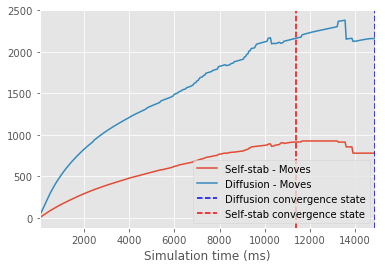

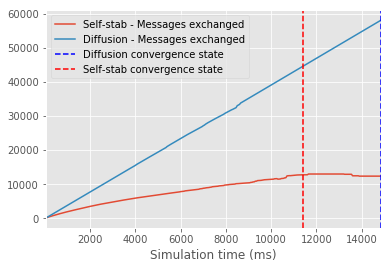

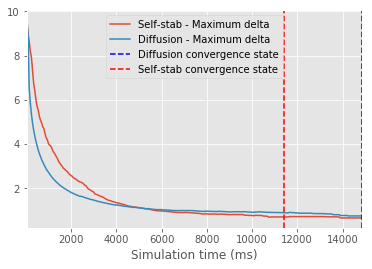

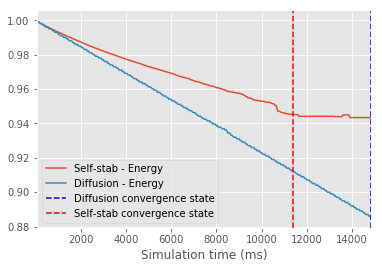

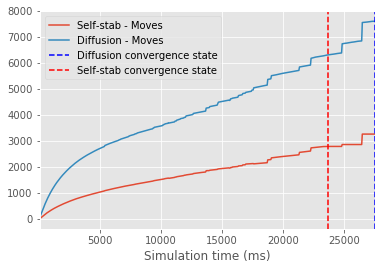

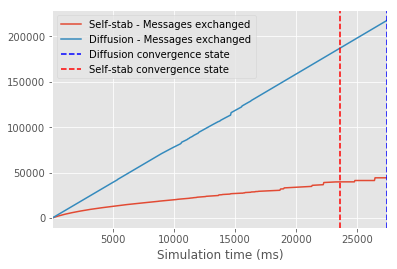

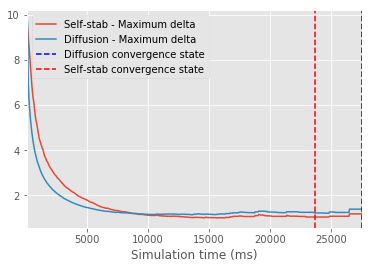

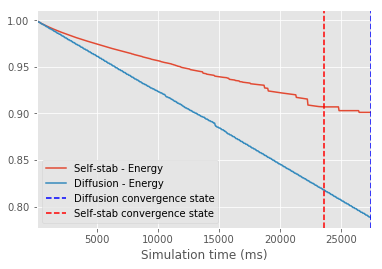

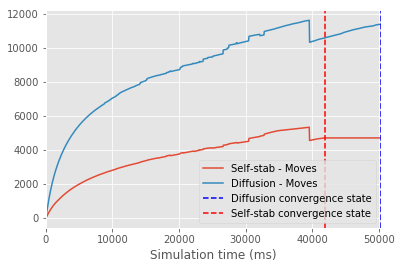

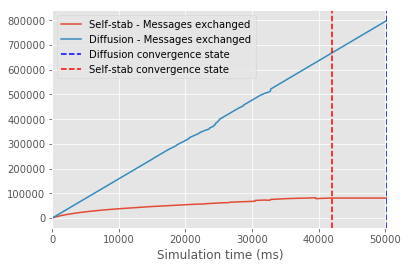

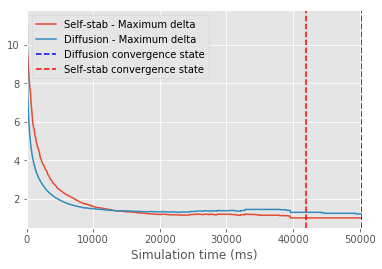

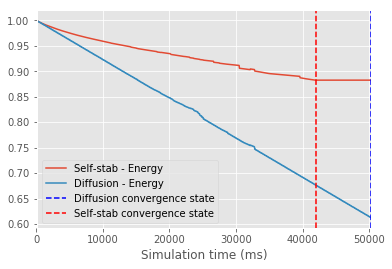

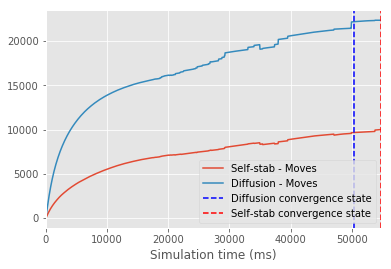

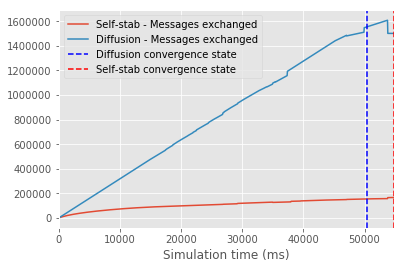

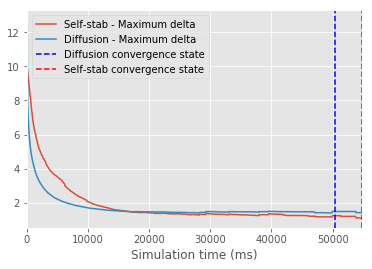

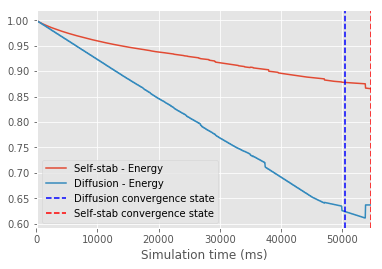

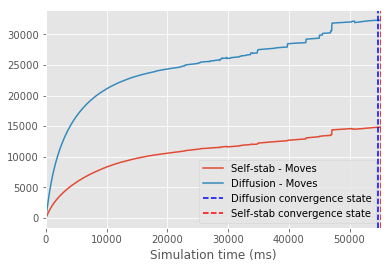

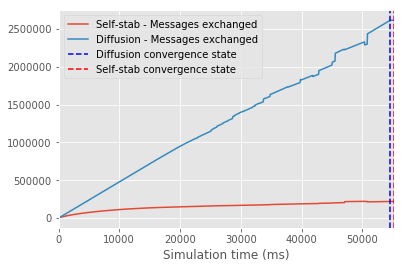

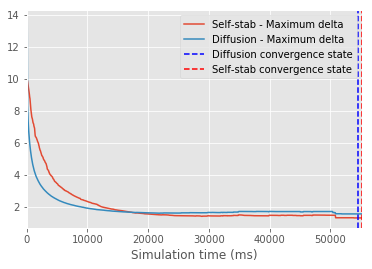

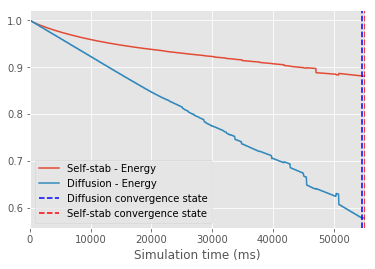

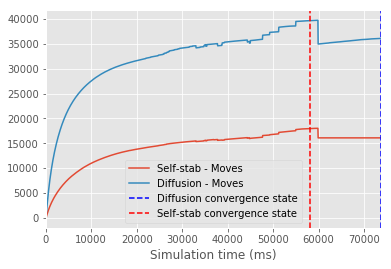

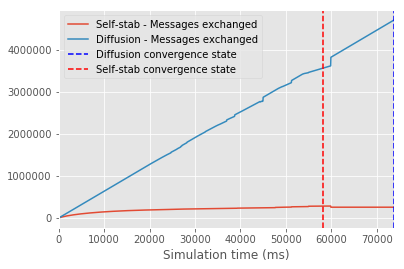

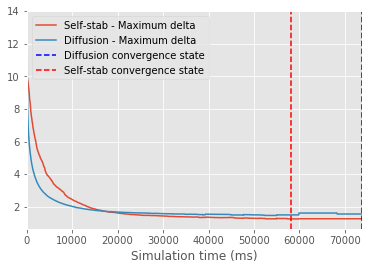

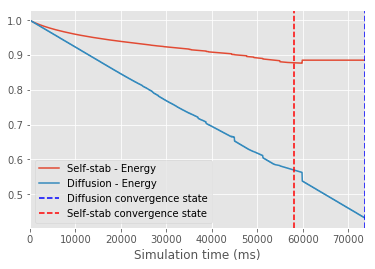

In [192]:
xplist = []
for nnode in [50, 100, 200, 400, 600, 800]:
    xplist.append(get_metrics_line(nnode, plot_experiment("nnodes_%d-distance_10" %nnode)))

## Scaling

In [193]:
synth = pd.concat(xplist)

In [194]:
synth

,Diffusion_sim_step,Diffusion_nmsg,Diffusion_delta,Diffusion_energy,Diffusion_nmove,Self-stab_sim_step,Self-stab_nmsg,Self-stab_delta,Self-stab_energy,Self-stab_nmove,Degree
50,14850.0,58114.0,0.750,0.885,2162.0,11400.0,12748.0,0.704,0.945160,914.0,1.960000
100,27500.0,217602.0,1.380,0.788,7603.0,23650.0,39860.0,1.030,0.907073,2788.0,1.980000
200,50300.0,800378.0,1.210,0.612,11379.0,41950.0,80813.0,1.000,0.882420,4700.0,1.990000
400,50400.0,1554504.0,1.505,0.624,22201.0,54750.0,166771.0,1.120,0.865310,9996.0,1.995000
600,54600.0,2615234.0,1.540,0.579,32307.0,55150.0,218930.0,1.290,0.880672,14850.0,1.996667
800,73700.0,4709306.0,1.560,0.432,36067.0,58100.0,283211.5,1.260,0.877773,17948.5,1.997500


In [195]:
synth["Self-stab_nmove"].values.reshape(1, 6)

array([[   914. ,   2788. ,   4700. ,   9996. ,  14850. ,  17948.5]])

In [196]:
from numpy import ones,vstack
from numpy.linalg import lstsq

points = [(x, y) for x, y in zip(synth.index.values, synth["Self-stab_nmove"].values)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]

print "Line Solution is y = %.2lf x + %.2lf" %(m,c)

Line Solution is y = 23.04 x + 276.19


In [197]:
synth["Self-stab_nmove"] / avg_move.index.values

50     18.280000
100    27.880000
200    23.500000
400    24.990000
600    24.750000
800    22.435625
Name: Self-stab_nmove, dtype: float64

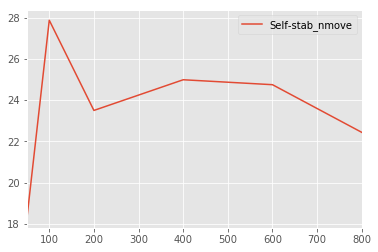

In [198]:
avg_move = synth[["Diffusion_nmove", "Self-stab_nmove"]].copy()
avg_move["Diffusion_nmove"] /= avg_move.index.values
avg_move["Self-stab_nmove"] /= avg_move.index.values

avg_move[["Self-stab_nmove"]].plot()
plt.savefig('outputs/images/avg_nmove.png')

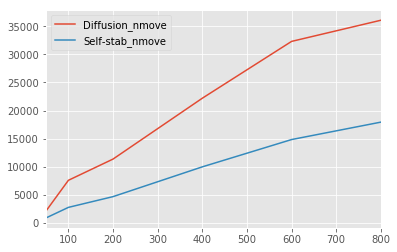

In [199]:
synth[["Diffusion_nmove", "Self-stab_nmove"]].plot()
plt.savefig('results/images/v2_nmove.png')

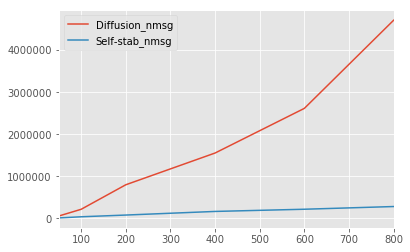

In [200]:
synth[["Diffusion_nmsg", "Self-stab_nmsg"]].plot()
plt.savefig('outputs/images/scale_nmsg.png')

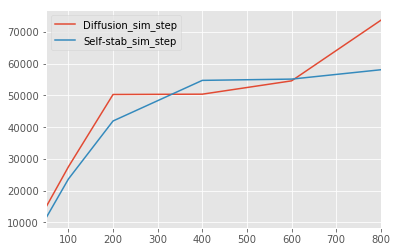

In [201]:
synth[["Diffusion_sim_step", "Self-stab_sim_step"]].plot()
plt.savefig('outputs/images/scale_sim_step.png')

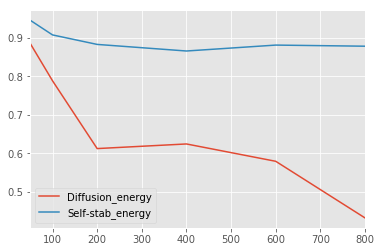

In [202]:
synth[["Diffusion_energy", "Self-stab_energy"]].plot()
plt.savefig('results/images/v2_energy.png')

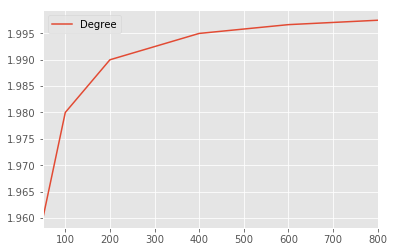

In [203]:
synth[["Degree"]].plot()
plt.savefig('outputs/images/scale_degree.png')